In [14]:
import json
import pandas as pd
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
import scipy.stats
import math
tree_file = '../../../nextstrain-build/phylogenetic_subsampling/auspice/mers.json'

In [15]:
#read in the tree
with open(tree_file, 'r') as f:
    tree_json = json.load(f)
    

#put tree in Bio.phylo format
tree = json_to_tree(tree_json)
# store the mutations on each terminal branch leading to tips
muts_on_branch = {}

In [16]:
# iterate through terminal branches on the tree to find what mutations are there
for terminal in tree.find_clades(terminal=True): 
    host = terminal.node_attrs.get('host', {})
    host_name = host.get('value', {})
    date = terminal.node_attrs.get('num_date', {})
    date_value = date.get('value', {})

    muts_on_branch[terminal.name] = {'host': host_name, 'date': date_value}
    # get the mutations on this node from the 'branch_attrs'
    ### write code here
    muts = terminal.branch_attrs.get('mutations', {})
    for gene, mutations in muts.items():
        if gene != 'nuc':
            continue
        # Ensure the node and gene are initialized in the dictionary
        if terminal.name not in muts_on_branch:
            muts_on_branch[terminal.name] = {}
        if gene not in muts_on_branch[terminal.name]:
            muts_on_branch[terminal.name][gene] = mutations

In [17]:
# confidence intervals
file = '../../intermediate-results-downsampling/nuc_mutations_by_gene.csv'
df = pd.read_csv(file)
stats_df = df.groupby(['Mutation', 'Host'])['Count'].agg(['mean', 'std']).reset_index()
n = 26 # number of genes
confidence = 0.95 # confidence interval 
stats_df = stats_df.assign(se=stats_df['std'] / math.sqrt(n))
h = stats_df['se'] * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
stats_df = stats_df.assign(confidence_interval=h*2)                         
human = stats_df.loc[stats_df["Host"] == 'Human']
camel = stats_df.loc[stats_df["Host"] == 'Camel']
human_ci = human['confidence_interval']
camel_ci = camel['confidence_interval']
print(camel_ci)


0      3.269570
2      6.897485
4      2.283974
6      2.567871
8      1.471572
10    26.974312
12     6.675360
14     2.068052
16     6.742029
18     2.428005
20    17.696919
22     2.887355
Name: confidence_interval, dtype: float64


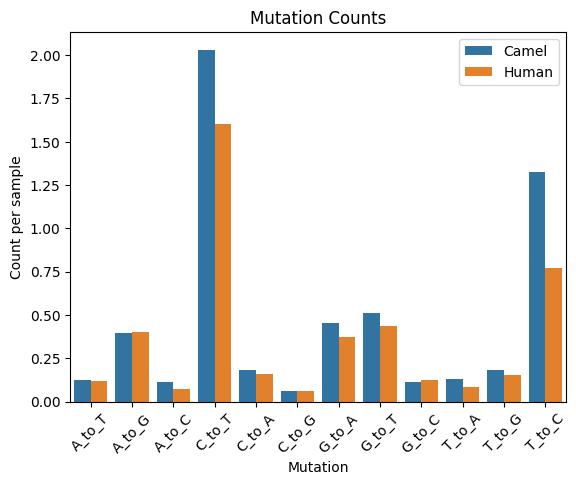

In [18]:
human_samples = 153
camel_samples = 413
genome_length = 30119
mut_counts = {
    'A_to_T': {'Camel': 0, 'Human': 0}, 'A_to_G': {'Camel': 0, 'Human': 0}, 'A_to_C': {'Camel': 0, 'Human': 0},
    'C_to_T': {'Camel': 0, 'Human': 0}, 'C_to_A': {'Camel': 0, 'Human': 0}, 'C_to_G': {'Camel': 0, 'Human': 0},
    'G_to_A': {'Camel': 0, 'Human': 0}, 'G_to_T': {'Camel': 0, 'Human': 0}, 'G_to_C': {'Camel': 0, 'Human': 0},
    'T_to_A': {'Camel': 0, 'Human': 0}, 'T_to_G': {'Camel': 0, 'Human': 0}, "T_to_C": {'Camel': 0, 'Human': 0}
}

for sample, info in muts_on_branch.items():
    host = info['host']
    if host == 'Bat' or host == 'Llama':
        continue
    nuc = info.get('nuc', {})
    
    for mut in nuc:
        key = f"{mut[0]}_to_{mut[-1]}"
        if key in mut_counts:
            if host == 'Human':
                mut_counts[key]['Human'] += 1
            elif host == 'Camel':
                mut_counts[key]['Camel'] += 1

data = []
mutations = []
camel_counts = []
human_counts = []

for mutation, counts in mut_counts.items():
    mutations.append(mutation)
    row_camel = {
        'Mutation': mutation,
        'Count': counts['Camel'] / camel_samples,
        'Host': 'Camel'
    }
    row_human = {
        'Mutation': mutation,
        'Count': counts['Human'] / human_samples,
        'Host': 'Human'
    }
    data.append(row_camel)
    data.append(row_human)

    camel_counts.append(counts['Camel'])
    human_counts.append(counts['Human'])

df = pd.DataFrame(data)

# Create a grouped bar plot
sns.barplot(x='Mutation', y='Count', hue='Host', data=df)

# Customize the plot
plt.title('Mutation Counts')
plt.xlabel('Mutation')
plt.ylabel('Count per sample')
plt.xticks(rotation=45)
plt.legend()  # Show legend for bar colors

# Show the plot
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'A_to_T'),
  Text(1, 0, 'A_to_G'),
  Text(2, 0, 'A_to_C'),
  Text(3, 0, 'C_to_T'),
  Text(4, 0, 'C_to_A'),
  Text(5, 0, 'C_to_G'),
  Text(6, 0, 'G_to_A'),
  Text(7, 0, 'G_to_T'),
  Text(8, 0, 'G_to_C'),
  Text(9, 0, 'T_to_A'),
  Text(10, 0, 'T_to_G'),
  Text(11, 0, 'T_to_C')])

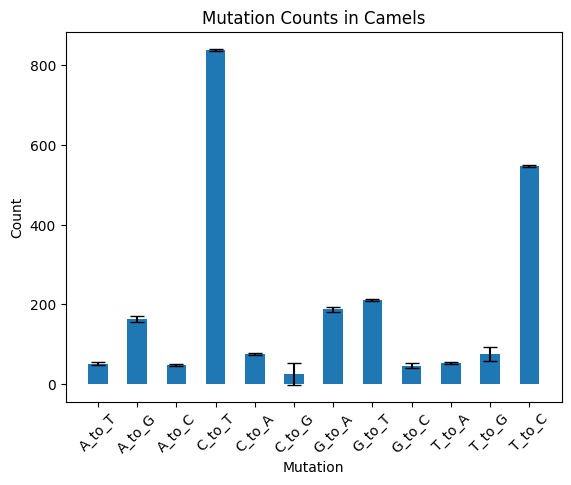

In [19]:
plt.bar(mutations, camel_counts, yerr=camel_ci, width = 0.5, capsize=5)
plt.title('Mutation Counts in Camels')
plt.xlabel('Mutation')
plt.ylabel('Count')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'A_to_T'),
  Text(1, 0, 'A_to_G'),
  Text(2, 0, 'A_to_C'),
  Text(3, 0, 'C_to_T'),
  Text(4, 0, 'C_to_A'),
  Text(5, 0, 'C_to_G'),
  Text(6, 0, 'G_to_A'),
  Text(7, 0, 'G_to_T'),
  Text(8, 0, 'G_to_C'),
  Text(9, 0, 'T_to_A'),
  Text(10, 0, 'T_to_G'),
  Text(11, 0, 'T_to_C')])

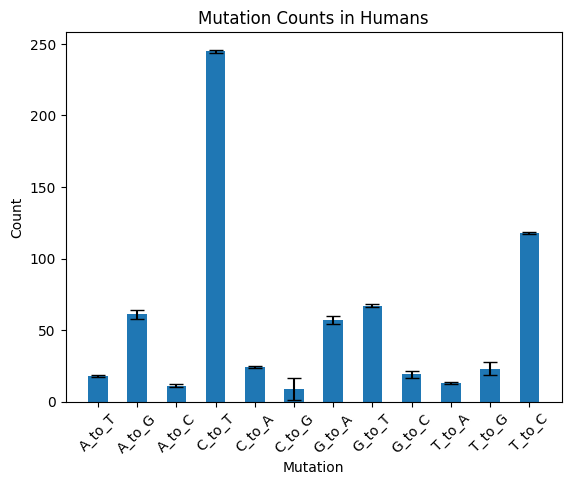

In [20]:
plt.bar(mutations, human_counts, yerr=human_ci, width = 0.5, capsize = 5)
plt.title('Mutation Counts in Humans')
plt.xlabel('Mutation')
plt.ylabel('Count')
plt.xticks(rotation=45)